Codigo de ejecucion del codigo de redes opticas

Using cpu device
------------------------------
| time/              |       |
|    fps             | 6546  |
|    iterations      | 1     |
|    time_elapsed    | 6     |
|    total_timesteps | 40960 |
------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 2007         |
|    iterations           | 2            |
|    time_elapsed         | 40           |
|    total_timesteps      | 81920        |
| train/                  |              |
|    approx_kl            | 0.0059587373 |
|    clip_fraction        | 0.0529       |
|    clip_range           | 0.2          |
|    entropy_loss         | -14.2        |
|    explained_variance   | -0.000367    |
|    learning_rate        | 0.00025      |
|    loss                 | 1.86e+05     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00494     |
|    std                  | 1            |
|    value_loss           | 4.83e+0

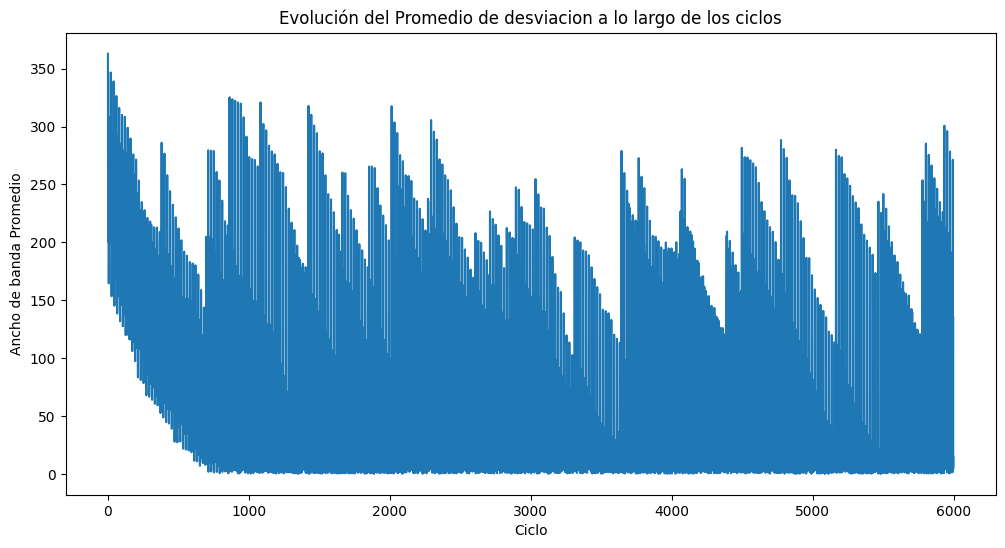

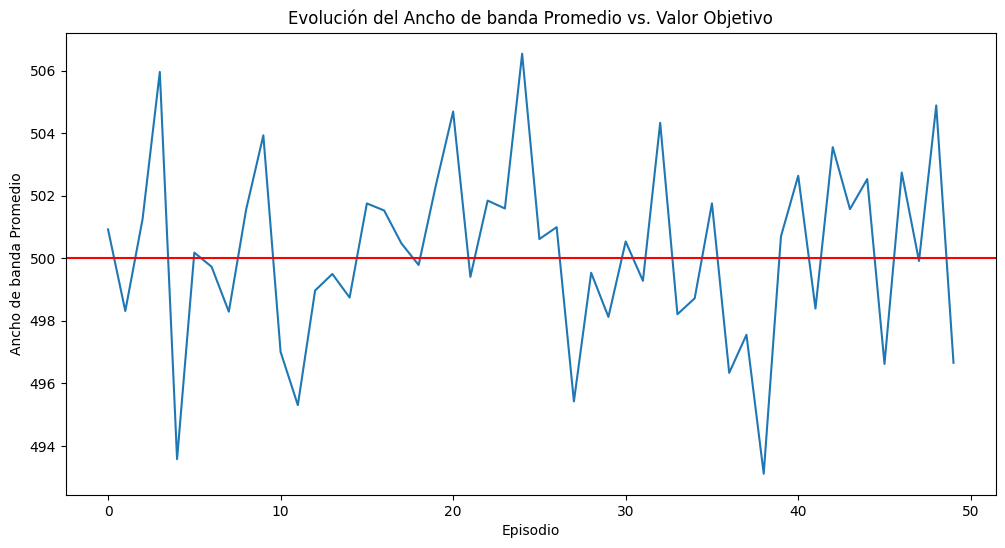

In [3]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.utils import set_random_seed
from custom_env.redes_opticas_env import RedesOpticasEnv  # Asegúrate de que esta ruta sea correcta

def make_env(env_id: str, rank: int, seed: int):
    def _init():
        try:
            env = gym.make(env_id, render_mode=None)  # Cambia a None si no quieres modo visual
            env.reset(seed=seed + rank)
            return env
        except Exception as e:
            print(f"Error al inicializar el entorno: {e}")
            raise e
    set_random_seed(seed)
    return _init

if __name__ == "__main__":
    env_id = 'RedesOpticasEnv-v0'  # Hay que asegurarse de que este ID coincida con el registrado
    num_test = 20  
    seed = np.random.randint(0, 10)
    vec_env = DummyVecEnv([make_env(env_id, i, seed) for i in range(num_test)])
    model = PPO("MultiInputPolicy", vec_env, verbose=1, n_steps=2048, learning_rate=0.00025, gamma=0.99, gae_lambda=0.95)
    model.learn(total_timesteps=200_000)

    # Fase de prueba
    num_test_episodes = 50  # Número de episodios de prueba

    Balloc=500

    episode_info = []  # Lista para guardar la información de cada episodio

    band_onu = [[] for _ in range(num_test_episodes)]  # Lista de listas para almacenar band_onus por episodio
    mean_band_onu = []  # Lista para almacenar promedios por episodio

    average_deviation=[]


    

    for episode in range(num_test_episodes):
        obs = vec_env.reset()  # Resetea el entorno al estado inicial
        done = np.array([False]*num_test)  # Inicializa 'done' para todos los entornos
        deviations = []  # Lista para guardar las desviaciones de cada paso


        while not done.all():
            action, _states = model.predict(obs, deterministic=True)  # Usa el modelo para predecir la acción
            obs, rewards, dones, info = vec_env.step(action)  # Ejecuta la acción en el entorno
            episode_info.append(info)  # Guarda la información del paso
            done |= dones  # Actualiza 'done' para todos los entornos
            for inf in info:
                deviation = inf['average_deviation_from_Balloc']
                deviations.append(deviation)

                band_onu[episode].append(inf['band_onus'])

        mean_band_onu.append(np.mean(band_onu[episode]))   

    #print(episode_info)

    print(f"En el ultimo episodio el ancho de banda de las onus del primer ciclo es de: {band_onu[len(band_onu)-1][0]}")
    print(f"En el ultimo episodio el ancho de banda de las onus del ultimo ciclo es de: {band_onu[len(band_onu)-1][len(band_onu[len(band_onu)-1])-1]}")

    print(f"En el primer episodio la desviacion del ancho de banda del primer ciclo es de: {abs(Balloc-band_onu[len(band_onu)-1][0])}")
    print(f"En el ultimo episodio la desviacion del ancho de banda del ultimo ciclo es de: {abs(Balloc-band_onu[len(band_onu)-1][len(band_onu[len(band_onu)-1])-1])}")

    deviation_avg_per_episode = []

    ultimo_episodio = band_onu[-1]  # Accede directamente al último episodio

    for i, ancho_de_banda in enumerate(ultimo_episodio):
        #print(f"El ancho de banda del ciclo {i+1} es de: {ancho_de_banda}")
        desviacion = np.abs(Balloc - ancho_de_banda)
        #print(f"La desviación del ancho de banda del ciclo {i+1} es de: {desviacion}")
        b=np.mean(desviacion)
        #print(f"La media de desviación del ancho de banda del ciclo {i+1} es de: {b}")
        deviation_avg_per_episode.append(b) #Vemos como varia la media de desviacion en cada ciclo de el ultimo episodio el ancho de banda
        #print(f"La desviacion media en el ciclo {i} del ultimo episodio es de: {deviation_avg_per_episode[i]}")


    # Grafica de la evolucion del promedio de la desviacion a lo largo de los ciclos
    plt.figure(figsize=(12, 6))
    plt.plot(deviation_avg_per_episode, label='Desviacion promedio por ciclo')
    plt.xlabel('Ciclo')
    plt.ylabel('Ancho de banda Promedio')
    plt.title('Evolución del Promedio de desviacion a lo largo de los ciclos')
    plt.savefig('ciclos.png')
    plt.show()

    objective_value=Balloc
    
    # Grafica del average del ancho de banda en los diferentes episodios
    plt.figure(figsize=(12, 6))
    plt.plot(mean_band_onu, label='Reward promedio por episodio')
    plt.axhline(y=objective_value, color='r', linestyle='-', label='Valor Objetivo')
    plt.xlabel('Episodio')
    plt.ylabel('Ancho de banda Promedio')
    plt.title('Evolución del Ancho de banda Promedio vs. Valor Objetivo')
    plt.savefig('banda.png')
    plt.show()
    
